In [1]:
from pycocotools.coco import COCO
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as A

In [2]:
def get_patch(annotation):
    patch = patches.Rectangle((annotation[0], annotation[1]), annotation[2], annotation[3], edgecolor='red', fill=False)
    return patch

def get_text_loc(annotation):
    return (annotation[0], annotation[1]-30)

def draw_bbox(frame, boxes, labels):
    '''
    Draw bounding box
    '''
    for box, label in zip(boxes, labels):
        # draw rectangle on frame
        box = list(map(int, box))
        # color_idx = [int(k) for k, v in label_list.items() if v == label][0]
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), [255, 0, 255], thickness=4) # palette[color_idx], thickness=4)

        # show scores and labels
        (w1, h1), _ = cv2.getTextSize(str(label), cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)
        
        cv2.rectangle(frame, (box[0], box[1]-10-h1), (box[0]+w1, box[1]), [255, 0, 255], -1) # palette[color_idx], -1)
        cv2.putText(frame, str(label), (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv2.LINE_AA)
    return frame

In [28]:
anno_root = '/opt/ml/finalproject/detection/data/eval/eval.json'
data_dir = './data/eval'

coco = COCO(anno_root)

ids = [866, 915, 916, 2456, 2679, 2923, 2962, 3705, 3709, 3826, 3827, 3838, 3839, 3862, 3863,
       4128, 4134, 4292, 4331, 4375, 4401, 4455, 4724, 4728, 4825, 4832, 4931, 4955, 5008, 5324,
       5389, 5401, 5439, 5442, 5443, 5608, 6396, 6397, 6438, 6440, 6441, 6521, 6611, 6620, 6623,
       6624, 6707, 6712, 6713, 6719, 6720, 6768, 6770, 6797, 6798, 6907, 6908, 6909, 6922, 6999,
       7000, 7320, 7705, 7900, 8383, 9183, 9697, 9698, 10965, 12929, 13069, 13186, 13555, 14577,
       14874, 15322, 15494, 15518, 15522, 15525, 15528, 15553, 15798, 20534, 20536, 20537, 
       20539, 20610, 22227, 24082, 24091, 25833, 25834, 25838, 25846, 25853, 25909, 25910, 
       26463, 26675, 26686, 29730]
images = coco.dataset["images"].copy()
image_paths, image_bboxes, image_labels, widths, heights = list(), list(), list(), list(), list()
for i in range(len(images)):
    if i in ids:
        image_info = coco.loadImgs(i)[0]
        image_paths.append(data_dir+image_info['path']+image_info['file_name'])
        
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = np.array([x['category_id'] for x in anns])

        image_bboxes.append(boxes)
        image_labels.append(labels)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [21]:
anno_root = '/opt/ml/finalproject/detection/data/sampled/sampled_train.json'
data_dir = './data/sampled'

coco = COCO(anno_root)

images = coco.dataset["images"].copy()
image_paths, image_bboxes, image_labels, widths, heights = list(), list(), list(), list(), list()
for i in range(len(images)):
    if i in [1505, 1509, 1513, 1515, 1519, 1647, 1739, 2007, 2051, 2677, 3406, 3820, 4131, 4139, 4143, 4193]:
        image_info = coco.loadImgs(i)[0]
        image_paths.append(data_dir+image_info['path']+image_info['file_name'])
        
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = np.array([x['category_id'] for x in anns])

        image_bboxes.append(boxes)
        image_labels.append(labels)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [29]:
len(image_paths)

102

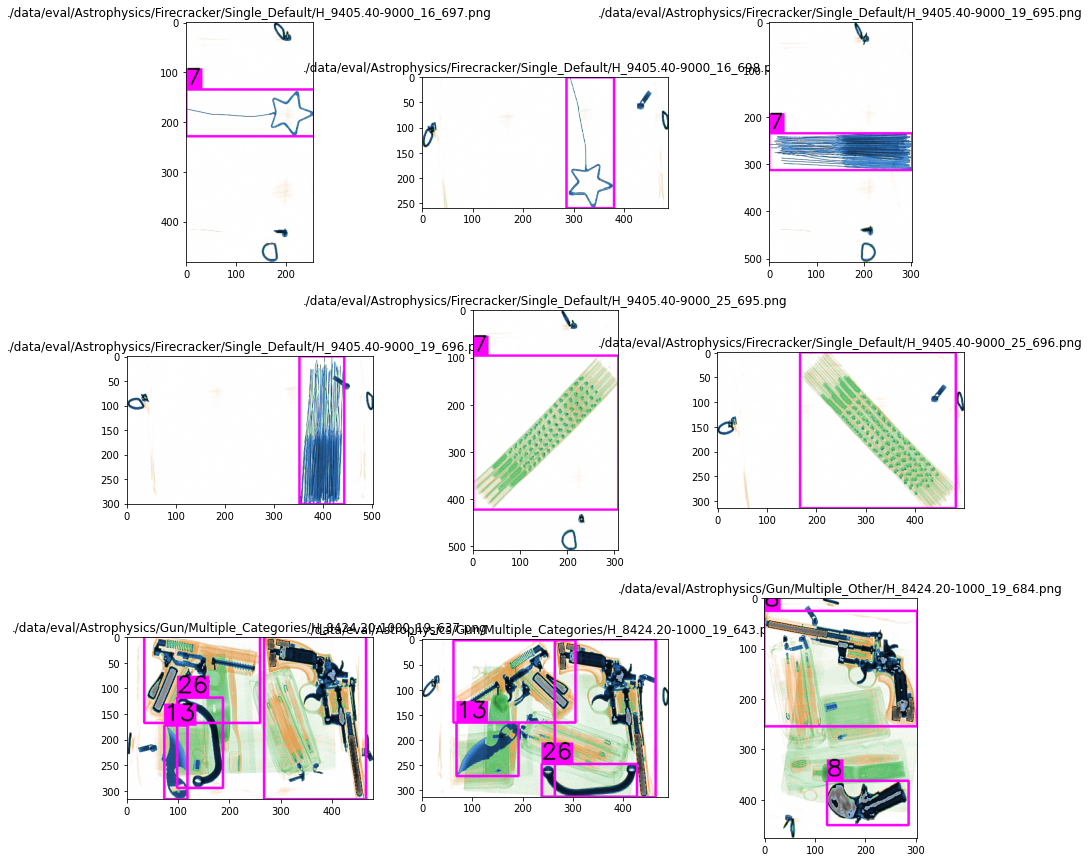

In [31]:
start = 0+9
frame_lst = []
path_lst = image_paths[start:start+9]
bbox_lst = image_bboxes[start:start+9]
label_lst = image_labels[start:start+9]

for i in range(len(path_lst)):
    frame = cv2.imread(path_lst[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = draw_bbox(frame, bbox_lst[i], label_lst[i])
    frame_lst.append(frame)

n, m = 3, 3
fig, axes = plt.subplots(n, m, figsize=(m*5, n*5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frame_lst[i])
    ax.set_title(path_lst[i])
plt.show()

In [7]:
len(image_paths)

16

In [5]:
widths.index(np.max(widths))

43

In [6]:
np.max(widths)

1498

In [7]:
np.max(heights)

613

In [8]:
image_labels[43]

array([24, 24, 24])

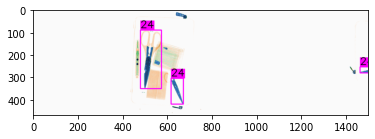

In [9]:
idx = 43
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame = draw_bbox(image, image_bboxes[idx], image_labels[idx])
plt.imshow(frame)
plt.show()

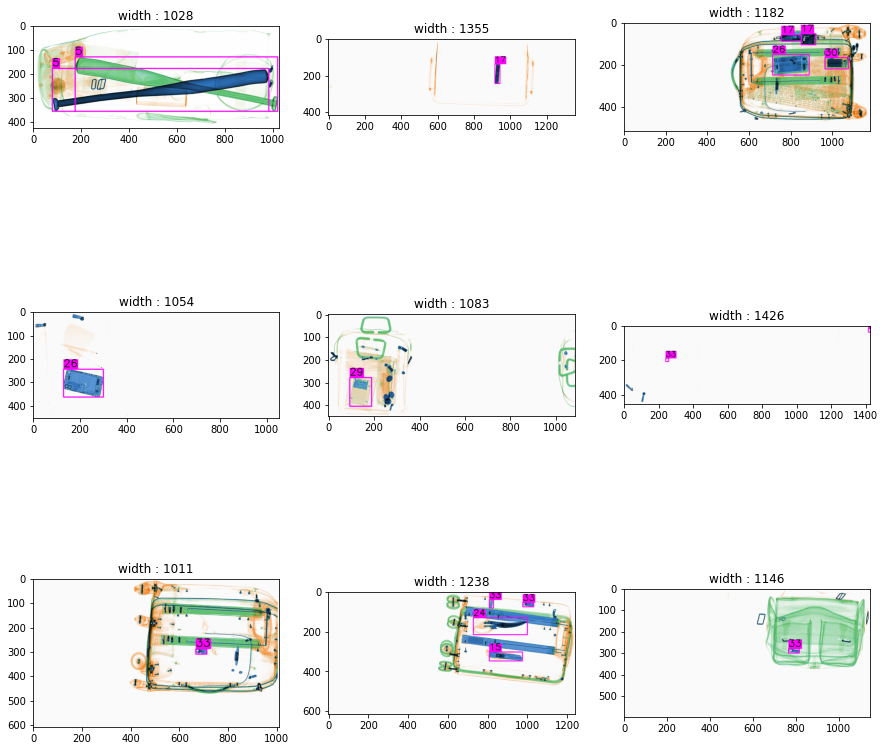

In [10]:
start = 0
frame_lst = []
path_lst = image_paths[start:start+9]
bbox_lst = image_bboxes[start:start+9]
label_lst = image_labels[start:start+9]
width_lst = widths[start:start+9]

for i in range(len(path_lst)):
    frame = cv2.imread(path_lst[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = draw_bbox(frame, bbox_lst[i], label_lst[i])
    frame_lst.append(frame)

n, m = 3, 3
fig, axes = plt.subplots(n, m, figsize=(m*5, n*5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frame_lst[i])
    ax.set_title('width : '+str(width_lst[i]))
plt.show()

(1024, 1024, 3)


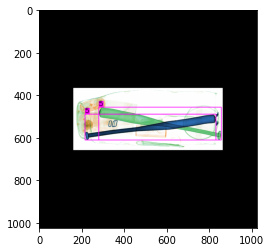

In [11]:
idx = 72
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = A.Compose([
    A.PadIfNeeded(min_height=1500, min_width=1500, border_mode=cv2.BORDER_CONSTANT),
    A.Resize(1024, 1024)
    ])

frame = draw_bbox(image, image_bboxes[idx], image_labels[idx])
frame = transform(image=frame)['image']

print(frame.shape)

plt.imshow(frame)
plt.show()

In [12]:
with open('sample_modified_train_dummy.json', 'r') as json_file:
    source_anns = json.load(json_file)

source_categories = source_anns['categories']
source_categories

[{'id': 34, 'name': 'ZippoOil', 'supercategory': '', 'color': ''},
 {'id': 4, 'name': 'Axe', 'supercategory': '', 'color': ''},
 {'id': 24, 'name': 'Scissors', 'supercategory': '', 'color': ''},
 {'id': 36, 'name': 'Plier', 'supercategory': '', 'color': ''},
 {'id': 15, 'name': 'Knife', 'supercategory': '', 'color': ''},
 {'id': 28, 'name': 'Spanner', 'supercategory': '', 'color': ''},
 {'id': 30, 'name': 'SupplymentaryBattery', 'supercategory': '', 'color': ''},
 {'id': 9, 'name': 'Gun', 'supercategory': '', 'color': ''},
 {'id': 12, 'name': 'HandCuffs', 'supercategory': '', 'color': ''},
 {'id': 17, 'name': 'Lighter', 'supercategory': '', 'color': ''},
 {'id': 37, 'name': 'Chisel', 'supercategory': '', 'color': ''},
 {'id': 25, 'name': 'Screwdriver', 'supercategory': '', 'color': ''},
 {'id': 41, 'name': 'Throwing Knife', 'supercategory': '', 'color': ''},
 {'id': 2, 'name': 'Alcohol', 'supercategory': '', 'color': ''},
 {'id': 22, 'name': 'PrtableGas', 'supercategory': '', 'color': 

In [13]:
from collections import Counter

classes = []
for l in image_labels:
    for c in l:
        for cat in source_categories:
            if cat['id'] == c:
                class_name = cat['name']
                classes.append(class_name)
counts = Counter(classes)
counts


Counter({'Match': 1,
         'MetalPipe': 54,
         'Saw': 4,
         'Spanner': 3,
         'Gun': 4,
         'Scissors': 22,
         'Plier': 8,
         'Chisel': 4,
         'HandCuffs': 5,
         'Throwing Knife': 3,
         'HDD': 1,
         'Knife': 2,
         'SmartPhone': 6,
         'SupplymentaryBattery': 9,
         'Hammer': 1,
         'USB': 9,
         'GunParts': 2,
         'Aerosol': 1,
         'Lighter': 6,
         'Firecracker': 4,
         'Bat': 18,
         'SSD': 1})

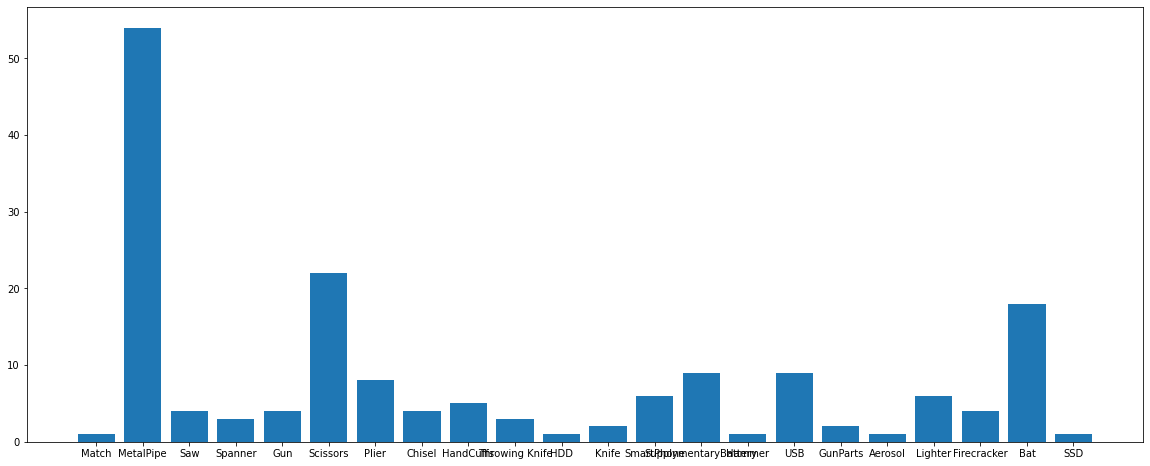

In [16]:
plt.rcParams["figure.figsize"] = (20, 8)
plt.bar([x for x in counts.keys()], counts.values())
plt.show()

loading annotations into memory...


Global seed set to 42


Done (t=0.21s)
creating index...
index created!
pred scores :  [0.4484529  0.41766348]


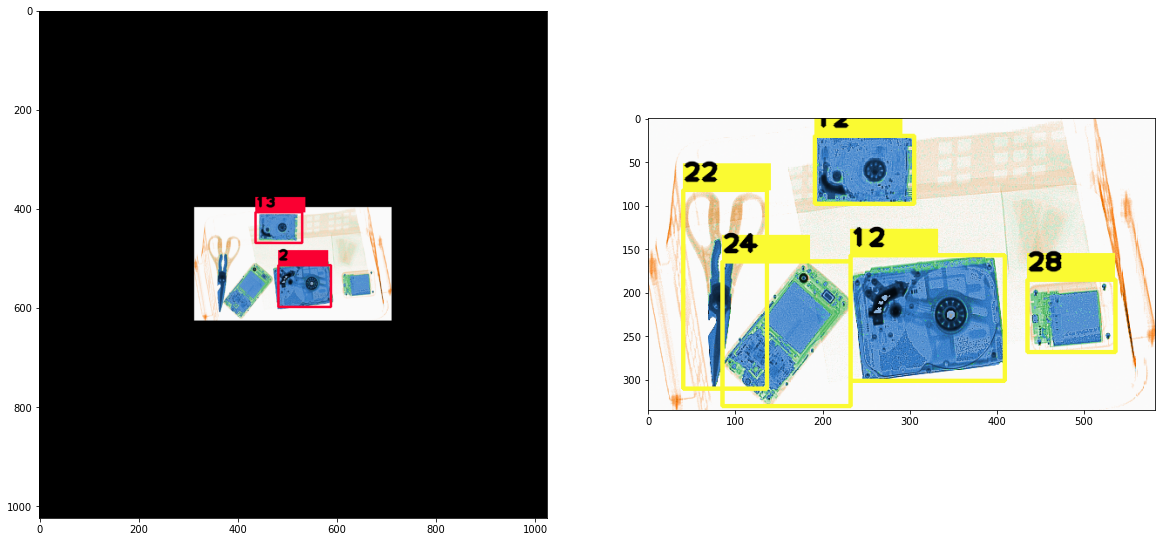

In [28]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import json

from models.fasterrcnn import LitModel

annotation = '/opt/ml/finalproject/detection/data/sampled/sampled_train.json'
img_path = '/opt/ml/finalproject/detection/data/sampled/Astrophysics/[Astro]HDD/HDD/Multiple_Categories/S_8471.70-2020_02_569.png'
coco = COCO(annotation)

with open(annotation) as json_file:
    source_anns = json.load(json_file)

source_images = source_anns['images']
source_annotations = source_anns['annotations']

for img in source_images:
    if img['file_name'] == 'S_8471.70-2020_02_569.png':
        img_id = img['id']

answer = []
for anno in source_annotations:
    if anno['image_id'] == img_id:
        answer.append(anno)

ans_bbox = []
ans_label = []
for ans in answer:
    ans_bbox.append(ans['bbox'])
    ans_label.append(ans['category_id'])

pl.seed_everything(42)

chk_path = '/opt/ml/finalproject/detection/lightning_logs/version_0/checkpoints/epoch=49-step=32749.ckpt'
model = LitModel().load_from_checkpoint(chk_path)
model.eval()

def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    return img

def valid_transform():
    return A.Compose([
        A.PadIfNeeded(min_height=1500, min_width=1500, border_mode=cv2.BORDER_CONSTANT),
        A.Resize(1024, 1024),
        # A.CenterCrop(800, 800),
        ToTensorV2()
    ])


image = read_img(img_path)
image2 = (image * 255).astype(np.uint8).copy()

transform = valid_transform()
image = transform(image=image)['image']
image = image.unsqueeze(dim=0)
with torch.no_grad():
    output = model(image)
    results = []
    labels = output[0]['labels'].detach().cpu().numpy()
    scores = output[0]['scores'].detach().cpu().numpy()
    boxes = output[0]['boxes'].detach().cpu().numpy()
    indexes = np.where(scores > 0.4)

    labels = labels[indexes]
    scores = scores[indexes]
    boxes = boxes[indexes]

# print(labels)
print('pred scores : ',scores)
# print(boxes)

image = image.squeeze(dim=0)
image = image.permute(1, 2, 0).numpy()
image= (image * 255).astype(np.uint8)

plt.figure(figsize=(20, 20))
for i in range(len(labels)):

    box = list(map(int, boxes[i]))
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (250, 0, 50), 4)

    text = str(labels[i])
    cv2.rectangle(image, (box[0], box[1] - 30), (box[0] + 100, box[1]), (250, 0, 50), -1)
    cv2.putText(image, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0), 4, cv2.LINE_AA)

plt.subplot(1, 2, 1)
plt.imshow(image)

for i in range(len(ans_label)):

    box = list(map(int, ans_bbox[i]))
    cv2.rectangle(image2, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), (250, 250, 50), 4)

    text = str(ans_label[i])
    cv2.rectangle(image2, (box[0], box[1] - 30), (box[0] + 100, box[1]), (250, 250, 50), -1)
    cv2.putText(image2, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0), 4, cv2.LINE_AA)

plt.subplot(1, 2, 2)
plt.imshow(image2)
